# Rebuilding PyTorch Essentials

**Exploring and re-implementing the essential PyTorch internals for training neural networks**
___

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Rebuilding-PyTorch-Essentials" data-toc-modified-id="Rebuilding-PyTorch-Essentials-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Rebuilding PyTorch Essentials</a></span><ul class="toc-item"><li><span><a href="#Import-Libraries" data-toc-modified-id="Import-Libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Libraries</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Pre-process-Data" data-toc-modified-id="Pre-process-Data-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Pre-process Data</a></span></li></ul></li><li><span><a href="#Bare-Training-Loop" data-toc-modified-id="Bare-Training-Loop-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Bare Training Loop</a></span><ul class="toc-item"><li><span><a href="#Build-Model" data-toc-modified-id="Build-Model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Build Model</a></span></li><li><span><a href="#Train-Model" data-toc-modified-id="Train-Model-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train Model</a></span></li><li><span><a href="#Evaluate-Model" data-toc-modified-id="Evaluate-Model-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Evaluate Model</a></span></li></ul></li><li><span><a href="#PyTorch-Data-Abstraction" data-toc-modified-id="PyTorch-Data-Abstraction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PyTorch Data Abstraction</a></span><ul class="toc-item"><li><span><a href="#Dataset" data-toc-modified-id="Dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Dataloader" data-toc-modified-id="Dataloader-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Dataloader</a></span></li><li><span><a href="#Random-Sampler" data-toc-modified-id="Random-Sampler-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Random Sampler</a></span></li></ul></li><li><span><a href="#PyTorch-Training-Abstraction" data-toc-modified-id="PyTorch-Training-Abstraction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>PyTorch Training Abstraction</a></span></li></ul></div>

## Import Libraries

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [2]:
dataset = MNIST(root="../data/")

In [3]:
x, y = dataset.data.float(), dataset.targets
x_train, x_test = x[:50000], x[50000:]
y_train, y_test = y[:50000], y[50000:]

x_train.shape, x_test.shape

(torch.Size([50000, 28, 28]), torch.Size([10000, 28, 28]))

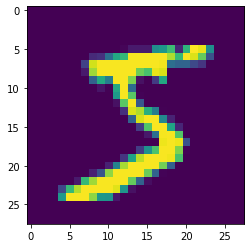

In [4]:
plt.imshow(x_train[0])

**Flatten**

In [5]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

## Pre-process Data

In [7]:
def normalize(x, mean, std): return (x-mean)/std

In [8]:
train_mean = x_train.mean()
train_std = x_train.std()

In [9]:
x_train = normalize(x_train, train_mean, train_std)
x_test = normalize(x_test, train_mean, train_std)

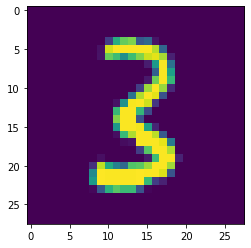

In [10]:
plt.imshow(x_test[0].view(28,28))

# Bare Training Loop

## Build Model

In [15]:
class FC(nn.Module):
    
    def __init__(self, x_dim, y_dim, h_dim):
        super().__init__()
        self.layers = [nn.Linear(x_dim, h_dim),
                       nn.ReLU(),
                       nn.Linear(h_dim, y_dim)]
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

**Model Config:**

In [11]:
n, m = x_train.shape
c = (y_train.max() - y_train.min()+1).item()
n, m, c

(50000, 784, 10)

In [17]:
model = FC(m, c, 300)

## Train Model

**Training Config:**

In [26]:
epochs = 10
lr = 1e-3
bs = 128
loss_fn = F.cross_entropy

In [29]:
for epoch in range(epochs):
    num_batches = (n-1)//bs
    for i in range(num_batches):
        # data minibatch
        start_idx, end_idx = bs*i, bs*(i+1)
        xb = x_train[start_idx:end_idx]
        yb = y_train[start_idx:end_idx]
        # forward pass 
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        # backpropagation
        loss.backward()
        # update model
        with torch.no_grad():
            for layer in model.layers:
                if hasattr(layer, "weight"):
                    layer.weight -= lr * layer.weight.grad
                    layer.weight.grad.zero_()
                if hasattr(layer, "bias"):
                    layer.bias -= lr * layer.bias.grad
                    layer.bias.grad.zero_()       
        

## Evaluate Model

In [32]:
def accuracy(input, target):
    input_pred = torch.argmax(input, dim=-1)
    return (input_pred==target).float().mean()

In [30]:
loss_fn(model(x_train), y_train)

tensor(0.4383, grad_fn=<NllLossBackward>)

In [34]:
accuracy(model(x_train), y_train)

tensor(0.8857)

# PyTorch Data Abstraction

## Dataset
**A simple wrapper for x's and y's**

In [36]:
class Dataset():
    
    def __init__(self, x, y):
        self.x, self.y = x, y
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

**Training Loop using Dataset abstraction**

In [37]:
train_ds = Dataset(x_train, y_train)
test_ds = Dataset(x_train, y_test)x

In [41]:
for epoch in range(epochs):
    num_batches = (n-1)//bs
    for i in range(num_batches):
        # data minibatch
        xb,yb = train_ds[bs*i:bs*(i+1)]
        # forward pass 
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        # backpropagation
        loss.backward()
        # update model
        with torch.no_grad():
            for layer in model.layers:
                if hasattr(layer, "weight"):
                    layer.weight -= lr * layer.weight.grad
                    layer.weight.grad.zero_()
                if hasattr(layer, "bias"):
                    layer.bias -= lr * layer.bias.grad
                    layer.bias.grad.zero_()       
        

In [42]:
accuracy(model(x_train), y_train)

tensor(0.9040)

## Dataloader
**Loading minibatches from a Dataset**

In [81]:
class DataLoader():
    
    def __init__(self, dataset, batch_size):
        self.ds, self.bs = dataset, batch_size
    
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs):
            yield self.ds[i:i+self.bs]

**Example:**

In [87]:
x = torch.Tensor(range(10))
y = x*x
dummy_ds = Dataset(x,y)
dummy_dl = DataLoader(dummy_ds, 2)

In [90]:
[(xb,yb) for xb,yb in dummy_dl]

[(tensor([0., 1.]), tensor([0., 1.])),
 (tensor([2., 3.]), tensor([4., 9.])),
 (tensor([4., 5.]), tensor([16., 25.])),
 (tensor([6., 7.]), tensor([36., 49.])),
 (tensor([8., 9.]), tensor([64., 81.]))]

**Training Loop using DataLoader abstraction**

In [92]:
train_ds = Dataset(x_train, y_train)
test_ds = Dataset(x_train, y_test)

train_dl = DataLoader(train_ds, bs)
test_dl = DataLoader(test_ds, bs)

In [93]:
for epoch in range(epochs):
    # data minibatch
    for xb,yb in train_dl:
        # forward pass 
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        # backpropagation
        loss.backward()
        # update model
        with torch.no_grad():
            for layer in model.layers:
                if hasattr(layer, "weight"):
                    layer.weight -= lr * layer.weight.grad
                    layer.weight.grad.zero_()
                if hasattr(layer, "bias"):
                    layer.bias -= lr * layer.bias.grad
                    layer.bias.grad.zero_()       
        

In [94]:
accuracy(model(x_train), y_train)

tensor(0.9143)

## Random Sampler
**Shuffles data during batch training**

In [104]:
class Sampler():
    
    def __init__(self, data_size, batch_size, shuffle):
        self.n, self.bs, self.shuffle = data_size, batch_size, shuffle
        
    def __iter__(self):
        sample_idx = torch.randperm(self.n) if self.shuffle else list(range(self.n))
        for i in range(0, self.n, self.bs):
            yield sample_idx[i : i+self.bs]

**Example:**

In [108]:
x = torch.Tensor(range(10))
y = x*x
dummy_samp = Sampler(10, 2, False)
print([samples for samples in dummy_samp])

[[0, 1], [2, 3], [4, 5], [6, 7], [8, 9]]


In [107]:
x = torch.Tensor(range(10))
y = x*x
dummy_samp = Sampler(10, 2, True)
print([samples for samples in dummy_samp])

[tensor([1, 4]), tensor([7, 2]), tensor([3, 5]), tensor([6, 0]), tensor([8, 9])]


**DataLoader with shuffling feature**

In [124]:
class DataLoader():
    
    def __init__(self, dataset, batch_size, sampler, collate_fn):
        self.ds, self.bs = dataset, batch_size        
        self.sampler, self.collate_fn = sampler, collate_fn
    
    def __iter__(self):
        for batch_idxs in self.sampler:
            yield self.collate_fn([self.ds[idx] for idx in batch_idxs])

In [125]:
def collate(batch):
    xs, ys = zip(*batch)
    return torch.stack(xs), torch.stack(ys)

**Example:**

In [127]:
x = torch.Tensor(range(10))
y = x*x

dummy_ds =  Dataset(x, y)
dummy_samp = Sampler(10, 2, False)
dummy_dl = DataLoader(dummy_ds, bs, dummy_samp, collate)

[batch for batch in dummy_dl]

[(tensor([0., 1.]), tensor([0., 1.])),
 (tensor([2., 3.]), tensor([4., 9.])),
 (tensor([4., 5.]), tensor([16., 25.])),
 (tensor([6., 7.]), tensor([36., 49.])),
 (tensor([8., 9.]), tensor([64., 81.]))]

In [128]:
x = torch.Tensor(range(10))
y = x*x

dummy_ds =  Dataset(x, y)
dummy_samp = Sampler(10, 2, True)
dummy_dl = DataLoader(dummy_ds, bs, dummy_samp, collate)

[batch for batch in dummy_dl]

[(tensor([5., 3.]), tensor([25.,  9.])),
 (tensor([7., 8.]), tensor([49., 64.])),
 (tensor([1., 2.]), tensor([1., 4.])),
 (tensor([9., 6.]), tensor([81., 36.])),
 (tensor([4., 0.]), tensor([16.,  0.]))]

**Training Loop with shuffled DataLoader**

In [129]:
train_ds = Dataset(x_train, y_train)
test_ds = Dataset(x_train, y_test)

train_samp = Sampler(len(train_ds), bs, shuffle=True)
test_samp = Sampler(len(test_ds), bs, shuffle=False)

train_dl = DataLoader(train_ds, bs, train_samp, collate)
test_dl = DataLoader(test_ds, bs, test_samp, collate)

In [130]:
for epoch in range(epochs):
    # data minibatch
    for xb,yb in train_dl:
        # forward pass 
        yb_pred = model(xb)
        loss = loss_fn(yb_pred, yb)
        # backpropagation
        loss.backward()
        # update model
        with torch.no_grad():
            for layer in model.layers:
                if hasattr(layer, "weight"):
                    layer.weight -= lr * layer.weight.grad
                    layer.weight.grad.zero_()
                if hasattr(layer, "bias"):
                    layer.bias -= lr * layer.bias.grad
                    layer.bias.grad.zero_()       
        

In [131]:
accuracy(model(x_train), y_train)

tensor(0.9220)

# PyTorch Training Abstraction